In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
# Load datasets
customers = pd.read_csv('../data/Customers.csv')
transactions = pd.read_csv('../data/Transactions.csv')

In [55]:
# Preprocessing
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
merged_data = pd.merge(customers, transactions, on='CustomerID', how='inner')

In [56]:
# Feature Engineering
merged_data['DaysSinceSignup'] = (merged_data['TransactionDate'] - merged_data['SignupDate']).dt.days
grouped = merged_data.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],  # Total and average transaction value
    'TransactionID': 'count',      # Transaction count
    'DaysSinceSignup': 'mean',     # Average days since signup
    'Region': 'first'              # Region
}).reset_index()
grouped.columns = ['CustomerID', 'TotalValue', 'AvgTransactionValue', 'TransactionCount', 'AvgDaysSinceSignup', 'Region']

In [57]:
# Encode categorical data
encoder = LabelEncoder()
grouped['RegionEncoded'] = encoder.fit_transform(grouped['Region'])

In [58]:
# Normalize features
features = grouped[['TotalValue', 'AvgTransactionValue', 'TransactionCount', 'AvgDaysSinceSignup', 'RegionEncoded']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [59]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=1.2, min_samples=1)
dbscan_labels = dbscan.fit_predict(features_scaled)

In [60]:
# Filter DBSCAN valid clusters (exclude noise)
valid_dbscan_mask = dbscan_labels != -1
db_index_dbscan = davies_bouldin_score(features_scaled[valid_dbscan_mask], dbscan_labels[valid_dbscan_mask])

In [61]:
# Print DBSCAN results
print(f"DBSCAN DB Index (filtered noise): {db_index_dbscan}")
print(f"Number of clusters (excluding noise): {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")

DBSCAN DB Index (filtered noise): 0.6602470494817454
Number of clusters (excluding noise): 15


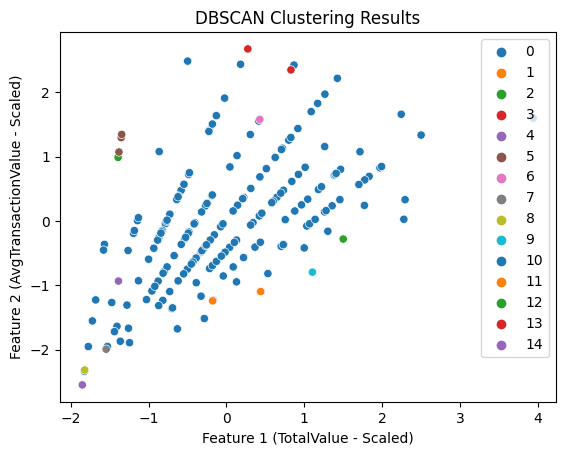

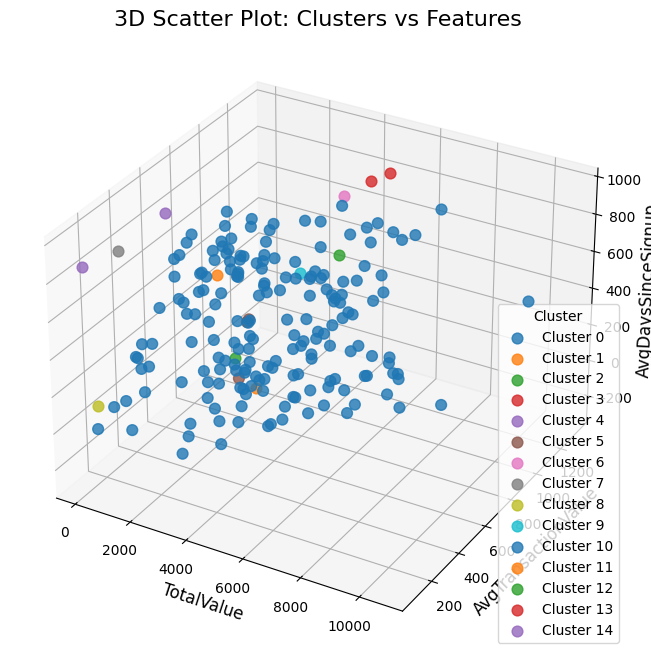

In [67]:
# Visualize DBSCAN results
grouped['Cluster'] = dbscan_labels
sns.scatterplot(
    x=features_scaled[:, 0],  # TotalValue (scaled)
    y=features_scaled[:, 1],  # AvgTransactionValue (scaled)
    hue=dbscan_labels,
    palette='tab10',
    legend='full'
)

plt.title('DBSCAN Clustering Results')
plt.xlabel('Feature 1 (TotalValue - Scaled)')
plt.ylabel('Feature 2 (AvgTransactionValue - Scaled)')
plt.show()

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in np.unique(dbscan_labels):
    mask = grouped['Cluster'] == cluster
    ax.scatter(
        grouped.loc[mask, 'TotalValue'],
        grouped.loc[mask, 'AvgTransactionValue'],
        grouped.loc[mask, 'AvgDaysSinceSignup'],
        label=f'Cluster {cluster}' if cluster != -1 else 'Noise',
        s=60,
        alpha=0.8
    )
ax.set_title('3D Scatter Plot: Clusters vs Features', fontsize=16)
ax.set_xlabel('TotalValue', fontsize=12)
ax.set_ylabel('AvgTransactionValue', fontsize=12)
ax.set_zlabel('AvgDaysSinceSignup', fontsize=12)
ax.legend(title='Cluster')
plt.show()